In [1]:
# THIS FILE IS DATA-DRIVEN AND WORKS WELL !

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [3]:
# Gen PWM function
def gen_pwm(sample_rate, pwm_frequency, duty_cycle, time):
    # PWM period
    pwm_period_in_cycles = int(np.floor(sample_rate / pwm_frequency))
    
    # Set up PWM signal
    pwm_signal = np.ones_like(time)
    for i in range(0, len(time) - 1, pwm_period_in_cycles):
        current_duty_cycle = duty_cycle[i]
        
        for j in range(pwm_period_in_cycles):
            on_time = pwm_period_in_cycles * current_duty_cycle
            if j < on_time:
                pwm_value = 1
            else:
                pwm_value = 0
            pwm_signal[i + j] = pwm_value
            
    return pwm_signal

In [4]:
# Simulation settings
sample_rate = 1e6   # 1 MHz
time_span = 120e-3  # 120 ms
period = 120e-3     # control period (time from .5 to 1 to 0)
pwm_frequency = 1e4 # 10 KHz

# Converter settings
L = 1e-2
C = 1e-5
V_i = 10
# R = 1

# Varying load
R_range = np.arange(1, 12, 0.5)

# PINN settings
epsilon = 1e-6

# time scale
time = np.arange(0, time_span + 1/sample_rate, 1/sample_rate)

# Allocate memory
time_length = len(time)
R_length = len(R_range)
i_L_0 = np.zeros((time_length, R_length))
V_o_0 = np.zeros((time_length, R_length))
i_L_solver = np.zeros((time_length, R_length))
V_o_solver = np.zeros((time_length, R_length))
d = np.zeros((time_length, R_length))
R = np.zeros((time_length, R_length))

# Training parameters
num_epochs = 100
mini_batch_size = 1000
learn_rate = 3e-2

# Timestep
delta_t = 1 / sample_rate

# Stimulus
duty_cycle = (np.sin(2 * np.pi / period * time) + 1) / 2
# Assuming `gen_pwm` is a custom function to generate PWM signals
# You need to implement this function or use an alternative method to generate PWM signals
pwm_signal = gen_pwm(sample_rate, pwm_frequency, duty_cycle, time)

# Initial conditions
i_L = np.ones_like(time)
V_o = np.ones_like(time)

In [5]:
# Simulate with Euler Backwards

rec_time = np.zeros_like(R)

# Implement Euler backward solver for each R
for k in range(1, len(R_range)):
    for i in range(1, len(time)):
        # Left-hand side matrix
        LHS = np.array([[1, delta_t / L], [-delta_t / C, delta_t / (C * R_range[k]) + 1]])
        
        # Right-hand side vector
        RHS = np.array([delta_t * pwm_signal[i] * V_i / L + i_L_solver[i - 1,k], V_o_solver[i - 1,k]])
        
        # Solve for the next step
        solved = np.linalg.solve(LHS, RHS)
        i_L_solver[i,k] = solved[0]
        V_o_solver[i,k] = solved[1]

        # Track R for each data point
        R[i,k] = R_range[k]
        rec_time[i,k] = time[i]
        
        # Update initial conditions if PWM signal changes
        if pwm_signal[i] != pwm_signal[i - 1]:
            i_L_0[i,k] = i_L_solver[i - 1,k]
            V_o_0[i,k] = V_o_solver[i - 1,k]
        else:
            i_L_0[i,k] = i_L_0[i - 1,k]
            V_o_0[i,k] = V_o_0[i - 1,k]

# Set up training data


### Here we flatten and puts all data in a line. Consider keeping each R seperate for training data

train_input = np.vstack([d.flatten(), i_L_0.flatten(), V_o_0.flatten(), rec_time.flatten(), R.flatten()])

i_L_solver = i_L_solver.flatten()
V_o_solver = V_o_solver.flatten()

# # Plot results for sanity check
# plt.figure()
# plt.plot(time, i_L_solver, label='Euler current')
# plt.plot(time, V_o_solver, label='Euler voltage')
# plt.ylabel('volts/amps')
# plt.xlabel('time (s)')
# plt.legend()
# plt.twinx()
# plt.plot(time, duty_cycle, 'g', label='PWM')
# plt.ylabel('duty cycle')
# plt.ylim(0, 1)
# plt.legend(loc='lower right')
# plt.title('Euler backward solver')
# plt.show()


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
input_features = train_input.T
output_labels = np.vstack([i_L_solver, V_o_solver]).T

# Convert to PyTorch tensors
inputs = torch.tensor(input_features, dtype=torch.float32)
labels = torch.tensor(output_labels, dtype=torch.float32)

# Check shapes
print("Input features shape:", inputs.shape)
print("Output labels shape:", labels.shape)


# Create DataLoader
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=mini_batch_size, shuffle=True)


Input features shape: torch.Size([2640022, 5])
Output labels shape: torch.Size([2640022, 2])


In [8]:
# from torch.utils.data.dataset import random_split

# # Define the sizes of the training and validation sets
# train_size = int(0.8 * len(dataset))  # 80% of the data for training
# val_size = len(dataset) - train_size  # Remaining 20% for validation

# # Split the dataset into training and validation sets
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# # Create DataLoaders for training and validation sets
# train_dataloader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=mini_batch_size)


In [9]:
# Set up Buck Converter NN

class BuckConverterNN(nn.Module):
    def __init__(self):
        super(BuckConverterNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(5, 50),
            nn.LayerNorm(50),
            nn.Sigmoid(),
            nn.Linear(50, 50),
            nn.LayerNorm(50),
            nn.Sigmoid(),
            nn.Linear(50,50),
            nn.LayerNorm(50),
            nn.Sigmoid(),
            nn.Linear(50, 2)
        )

        # self.epsilon = torch.finfo(torch.float32).eps

    def forward(self, x):
        # Apply log activation function with epsilon for numerical stability
        x = torch.log(epsilon + x)
        return self.layers(x)
    
model = BuckConverterNN().to(device)

In [10]:
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learn_rate)

# Define learning rate scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

# Define loss function
criterion = nn.MSELoss()  

In [11]:
# Train the model
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('[%d] training loss: %.3f' % (epoch + 1, running_loss / len(dataloader)))
    

print('Finished Training')

[1] training loss: 0.327
[2] training loss: 0.004
[3] training loss: 0.003
Finished Training


In [12]:
# # Train the model
# num_epochs = 100
# for epoch in range(num_epochs):
#     # Training phase
#     model.train()
#     running_train_loss = 0.0
#     for i, train_data in enumerate(train_dataloader, 0):
#         train_inputs, train_labels = train_data[0].to(device), train_data[1].to(device)  # Move data to device
#         optimizer.zero_grad()
#         train_outputs = model(train_inputs)
#         train_loss = criterion(train_outputs, train_labels)
#         train_loss.backward()
#         optimizer.step()
#         running_train_loss += train_loss.item()
#     train_loss_avg = running_train_loss / len(train_dataloader)
    
#     # Validation phase
#     model.eval()  # Set model to evaluation mode
#     running_val_loss = 0.0
#     with torch.no_grad():
#         for val_data in val_dataloader:
#             val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)  # Move data to device
#             val_outputs = model(val_inputs)
#             val_loss = criterion(val_outputs, val_labels)
#             running_val_loss += val_loss.item()
#     val_loss_avg = running_val_loss / len(val_dataloader)
    
#     # Print training and validation loss for each epoch
#     print('[%d] Training Loss: %.3f | Validation Loss: %.3f' % (epoch + 1, train_loss_avg, val_loss_avg))

# print('Finished Training')

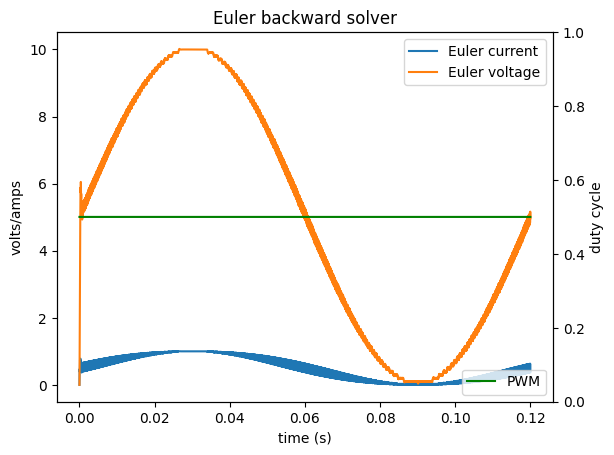

Input features shape: torch.Size([120001, 5])
Output labels shape: torch.Size([120001, 2])


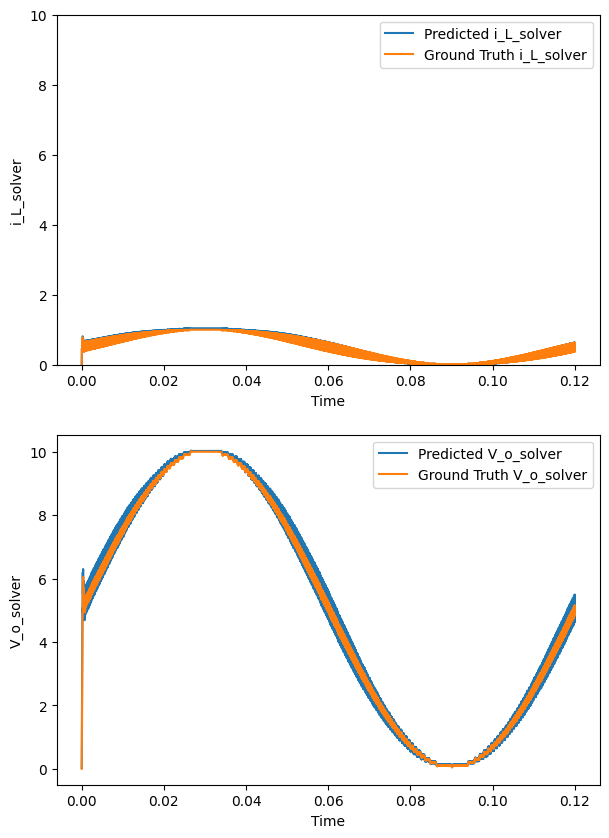

In [13]:
## Now TEST on a different load
## This does not generalize well to varying load. Lets add load as a variable to the network

# Simulation settings
sample_rate = 1e6   # 1 MHz
time_span = 120e-3  # 120 ms
period = 120e-3     # control period (time from .5 to 1 to 0)
pwm_frequency = 1e4 # 10 KHz

# Converter settings
L = 1e-3
C = 1e-5
V_i = 10
# R=1

# PINN settings
epsilon = 1e-6

# time scale
time = np.arange(0, time_span + 1/sample_rate, 1/sample_rate)



# Allocate memory
time_length = len(time)
i_L_0 = np.ones(time_length)
V_o_0 = np.ones(time_length)
i_L_solver = np.ones(time_length)
V_o_solver = np.ones(time_length)
d = np.zeros(time_length)

R = np.zeros(time_length)
# Set each element of R to the value x using a for loop
for i in range(time_length):
    # R[i] = 12
    R[i] = 10


# Training parameters
num_epochs = 100
mini_batch_size = 1000
learn_rate = 3e-2

# Timestep
delta_t = 1 / sample_rate

# Stimulus
# duty_cycle = (np.sin(2 * np.pi / period * time) + 1) / 2
#####
# # Make sure we create a duty cycle array of exactly the right length
# quarter_length = time_length // 4  # Use integer division
# remainder = time_length % 4  # Get any remaining points
# # Create base arrays
# duty_cycle_2 = np.full(quarter_length, 1)
# duty_cycle_1 = np.full(quarter_length, 0)
# duty_cycle_4 = np.full(quarter_length, 1)
# duty_cycle_3 = np.full(quarter_length + remainder, 0)  # Add remainder to last segment
# # Concatenate
# duty_cycle = np.concatenate([duty_cycle_1, duty_cycle_2, duty_cycle_3, duty_cycle_4])
# #####
duty_cycle = np.full(time_length, 0.5)

# Assuming `gen_pwm` is a custom function to generate PWM signals
# You need to implement this function or use an alternative method to generate PWM signals
# pwm_signal = gen_pwm(sample_rate, pwm_frequency, duty_cycle, time)

# Initial conditions
i_L = np.ones_like(time)
V_o = np.ones_like(time)

# Simulate with Euler Backwards
# Initialize arrays
i_L_solver = np.zeros_like(time)
V_o_solver = np.zeros_like(time)

# Initialize previous solutions
i_L_0 = np.copy(i_L_solver)
V_o_0 = np.copy(V_o_solver)

# Implement Euler backward solver
for i in range(1, len(time)):
    # Left-hand side matrix
    LHS = np.array([[1, delta_t / L], [-delta_t / C, delta_t / (C * R[i]) + 1]])
    
    # Right-hand side vector
    RHS = np.array([delta_t * pwm_signal[i] * V_i / L + i_L_solver[i - 1], V_o_solver[i - 1]])
    
    # Solve for the next step
    solved = np.linalg.solve(LHS, RHS)
    i_L_solver[i] = solved[0]
    V_o_solver[i] = solved[1]
    
    # # Update initial conditions if PWM signal changes
    # if pwm_signal[i] != pwm_signal[i - 1]:
    #     i_L_0[i] = i_L_solver[i - 1]
    #     V_o_0[i] = V_o_solver[i - 1]
    # else:
    #     i_L_0[i] = i_L_0[i - 1]
    #     V_o_0[i] = V_o_0[i - 1]

# Set up training data
train_input = np.vstack([d, i_L_solver, V_o_solver, time, R])

# Plot results for sanity check
plt.figure()
plt.plot(time, i_L_solver, label='Euler current')
plt.plot(time, V_o_solver, label='Euler voltage')
plt.ylabel('volts/amps')
plt.xlabel('time (s)')
plt.legend()
plt.twinx()
plt.plot(time, duty_cycle, 'g', label='PWM')
plt.ylabel('duty cycle')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.title('Euler backward solver')
plt.show()


input_features = train_input.T
output_labels = np.vstack([i_L_solver, V_o_solver]).T

# Convert to PyTorch tensors
inputs = torch.tensor(input_features, dtype=torch.float32)
labels = torch.tensor(output_labels, dtype=torch.float32)

# Check shapes
print("Input features shape:", inputs.shape)
print("Output labels shape:", labels.shape)


# Create DataLoader
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=mini_batch_size, shuffle=False)


# Set the model to evaluation mode
model.eval()

# List to store predicted labels
predicted_labels = []

# Make predictions for the entire dataset
with torch.no_grad():
    for inputs_batch, _ in dataloader:  # We only need the inputs_batch, ignoring the labels
        inputs_batch = inputs_batch.to(device)  # Move inputs to GPU
        predicted_labels_batch = model(inputs_batch)
        predicted_labels.append(predicted_labels_batch.cpu().numpy())

# Concatenate the predicted labels from all batches
predicted_labels = np.concatenate(predicted_labels)

# Plot the predictions and ground truth values over time
plt.figure(figsize=(7, 10))

# Plot i_L_solver
plt.subplot(2, 1, 1)
plt.plot(time, predicted_labels[:, 0], label='Predicted i_L_solver')
plt.plot(time, output_labels[:, 0], label='Ground Truth i_L_solver')
plt.xlabel('Time')
plt.ylabel('i_L_solver')
plt.ylim(0, 10)
plt.legend()

# Plot V_o_solvera
plt.subplot(2, 1, 2)
plt.plot(time, predicted_labels[:, 1], label='Predicted V_o_solver')
plt.plot(time, output_labels[:, 1], label='Ground Truth V_o_solver')
plt.xlabel('Time')
plt.ylabel('V_o_solver')
# plt.ylim(0, 10)
plt.legend()

plt.show()


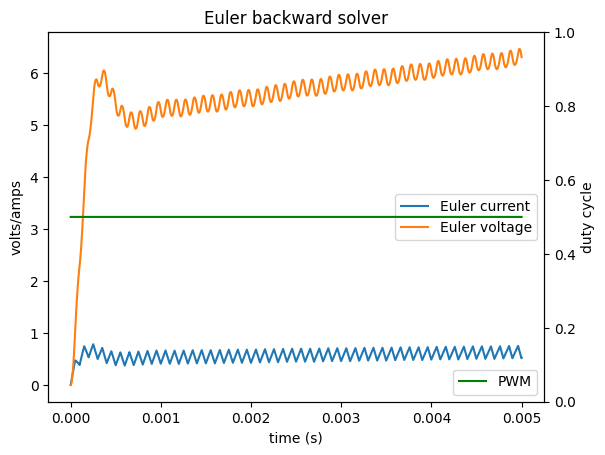

Input features shape: torch.Size([5002, 5])
Output labels shape: torch.Size([5002, 2])


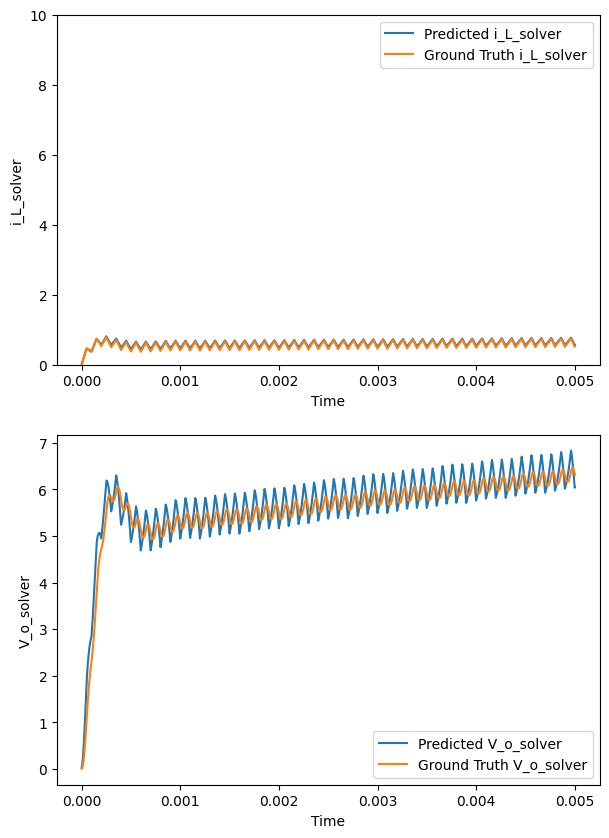

In [14]:
## Now TEST on a different load
## This does not generalize well to varying load. Lets add load as a variable to the network

# Simulation settings
sample_rate = 1e6   # 1 MHz
time_span = 5e-3  # 120 ms
period = 5e-3     # control period (time from .5 to 1 to 0)
pwm_frequency = 1e4 # 10 KHz

# Converter settings
L = 1e-3
C = 1e-5
V_i = 10
# R=1

# PINN settings
epsilon = 1e-6

# time scale
time = np.arange(0, time_span + 1/sample_rate, 1/sample_rate)



# Allocate memory
time_length = len(time)
i_L_0 = np.ones(time_length)
V_o_0 = np.ones(time_length)
i_L_solver = np.ones(time_length)
V_o_solver = np.ones(time_length)
d = np.zeros(time_length)

R = np.zeros(time_length)
# Set each element of R to the value x using a for loop
for i in range(time_length):
    # R[i] = 12
    R[i] = 10


# Training parameters
num_epochs = 100
mini_batch_size = 1000
learn_rate = 3e-2

# Timestep
delta_t = 1 / sample_rate

# Stimulus
# duty_cycle = (np.sin(2 * np.pi / period * time) + 1) / 2
#####
# # Make sure we create a duty cycle array of exactly the right length
# quarter_length = time_length // 4  # Use integer division
# remainder = time_length % 4  # Get any remaining points
# # Create base arrays
# duty_cycle_2 = np.full(quarter_length, 1)
# duty_cycle_1 = np.full(quarter_length, 0)
# duty_cycle_4 = np.full(quarter_length, 1)
# duty_cycle_3 = np.full(quarter_length + remainder, 0)  # Add remainder to last segment
# # Concatenate
# duty_cycle = np.concatenate([duty_cycle_1, duty_cycle_2, duty_cycle_3, duty_cycle_4])
# #####
duty_cycle = np.full(time_length, 0.5)

# Assuming `gen_pwm` is a custom function to generate PWM signals
# You need to implement this function or use an alternative method to generate PWM signals
# pwm_signal = gen_pwm(sample_rate, pwm_frequency, duty_cycle, time)

# Initial conditions
i_L = np.ones_like(time)
V_o = np.ones_like(time)

# Simulate with Euler Backwards
# Initialize arrays
i_L_solver = np.zeros_like(time)
V_o_solver = np.zeros_like(time)

# Initialize previous solutions
i_L_0 = np.copy(i_L_solver)
V_o_0 = np.copy(V_o_solver)

# Implement Euler backward solver
for i in range(1, len(time)):
    # Left-hand side matrix
    LHS = np.array([[1, delta_t / L], [-delta_t / C, delta_t / (C * R[i]) + 1]])
    
    # Right-hand side vector
    RHS = np.array([delta_t * pwm_signal[i] * V_i / L + i_L_solver[i - 1], V_o_solver[i - 1]])
    
    # Solve for the next step
    solved = np.linalg.solve(LHS, RHS)
    i_L_solver[i] = solved[0]
    V_o_solver[i] = solved[1]
    
    # # Update initial conditions if PWM signal changes
    # if pwm_signal[i] != pwm_signal[i - 1]:
    #     i_L_0[i] = i_L_solver[i - 1]
    #     V_o_0[i] = V_o_solver[i - 1]
    # else:
    #     i_L_0[i] = i_L_0[i - 1]
    #     V_o_0[i] = V_o_0[i - 1]

# Set up training data
train_input = np.vstack([d, i_L_solver, V_o_solver, time, R])

# Plot results for sanity check
plt.figure()
plt.plot(time, i_L_solver, label='Euler current')
plt.plot(time, V_o_solver, label='Euler voltage')
plt.ylabel('volts/amps')
plt.xlabel('time (s)')
plt.legend()
plt.twinx()
plt.plot(time, duty_cycle, 'g', label='PWM')
plt.ylabel('duty cycle')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.title('Euler backward solver')
plt.show()


input_features = train_input.T
output_labels = np.vstack([i_L_solver, V_o_solver]).T

# Convert to PyTorch tensors
inputs = torch.tensor(input_features, dtype=torch.float32)
labels = torch.tensor(output_labels, dtype=torch.float32)

# Check shapes
print("Input features shape:", inputs.shape)
print("Output labels shape:", labels.shape)


# Create DataLoader
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=mini_batch_size, shuffle=False)


# Set the model to evaluation mode
model.eval()

# List to store predicted labels
predicted_labels = []

# Make predictions for the entire dataset
with torch.no_grad():
    for inputs_batch, _ in dataloader:  # We only need the inputs_batch, ignoring the labels
        inputs_batch = inputs_batch.to(device)  # Move inputs to GPU
        predicted_labels_batch = model(inputs_batch)
        predicted_labels.append(predicted_labels_batch.cpu().numpy())

# Concatenate the predicted labels from all batches
predicted_labels = np.concatenate(predicted_labels)

# Plot the predictions and ground truth values over time
plt.figure(figsize=(7, 10))

# Plot i_L_solver
plt.subplot(2, 1, 1)
plt.plot(time, predicted_labels[:, 0], label='Predicted i_L_solver')
plt.plot(time, output_labels[:, 0], label='Ground Truth i_L_solver')
plt.xlabel('Time')
plt.ylabel('i_L_solver')
plt.ylim(0, 10)
plt.legend()

# Plot V_o_solvera
plt.subplot(2, 1, 2)
plt.plot(time, predicted_labels[:, 1], label='Predicted V_o_solver')
plt.plot(time, output_labels[:, 1], label='Ground Truth V_o_solver')
plt.xlabel('Time')
plt.ylabel('V_o_solver')
# plt.ylim(0, 10)
plt.legend()

plt.show()
